<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/02_BasicMLAlgorithms/examples/clustering_Amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Customer Reviews

Data source: https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products

This is a list of over 34,000 consumer reviews for Amazon products like the Kindle, Fire TV Stick, and more provided by Datafiniti's Product Database. The dataset includes basic product information, rating, review text, and more for each product.

Note that this is a sample of a large dataset. The full dataset is available through Datafiniti.

### Tasks:
1. Data engineering
2. Feature engineering
3. Cluster to find patterns
  - Kmeans
  - Hierarchical clustering
4. Evaluate metrics

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import scipy
from sklearn.decomposition import TruncatedSVD

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style='whitegrid')

%matplotlib inline

In [0]:
df = pd.read_csv('https://github.com/lisaong/mldds-courseware/blob/master/data/amazon-reviews/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv?raw=true')
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-09-03T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-06-06T00:00:00.000Z,NaN,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-20T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2017-11-02T17:33:31.000Z,NaN,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,Amazon,B00ZV9PXP2,2018-04-24T00:00:00.000Z,NaN,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


## Data Engineering

Explore data to see which columns we would like to cluster

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
id                     5000 non-null object
dateAdded              5000 non-null object
dateUpdated            5000 non-null object
name                   5000 non-null object
asins                  5000 non-null object
brand                  5000 non-null object
categories             5000 non-null object
primaryCategories      5000 non-null object
imageURLs              5000 non-null object
keys                   5000 non-null object
manufacturer           5000 non-null object
manufacturerNumber     5000 non-null object
reviews.date           5000 non-null object
reviews.dateAdded      1052 non-null object
reviews.dateSeen       5000 non-null object
reviews.doRecommend    5000 non-null bool
reviews.id             29 non-null float64
reviews.numHelpful     5000 non-null int64
reviews.rating         5000 non-null int64
reviews.sourceURLs     5000 non-null object
reviews.text      

### Ignore columns

Too unique: 
- id, dateAdded, dateUpdated, imageURLs, reviews.date*, reviews.id, reviews.sourceURLs, asins, sourceURLs

Less relevant for finding patterns in reviews (maybe for other problems like supervised learning or recommender systems): 
- reviews.username, manufacturerNumber, manufacturer, reviews.numHelpful, reviews.rating, reviews.doRecommend, categories

In [0]:
columns = ['name', 'brand', 'primaryCategories', 'reviews.title', 'reviews.text']

df = df[columns]
df.head()

,name,brand,primaryCategories,reviews.title,reviews.text
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,Electronics,Too small,I thought it would be as big as small paper bu...
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,Electronics,Great light reader. Easy to use at the beach,This kindle is light and easy to use especiall...
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,Electronics,Great for the price,Didnt know how much i'd use a kindle so went f...
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,Electronics,A Great Buy,I am 100 happy with my purchase. I caught it o...
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Amazon,Electronics,Solid entry-level Kindle. Great for kids,Solid entry level Kindle. Great for kids. Gift...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
name                 5000 non-null object
brand                5000 non-null object
primaryCategories    5000 non-null object
reviews.title        4987 non-null object
reviews.text         5000 non-null object
dtypes: object(5)
memory usage: 195.4+ KB


## Clean missing values

In [0]:
mask = df['reviews.title'].isnull()
df[mask]

,name,brand,primaryCategories,reviews.title,reviews.text
334,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,I love it. It does so much and is so easy to u...
335,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,I love the Echo show. I have found so many use...
347,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,I bought the echo show for my mom for her birt...
395,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,This was bought for a gift. But it looks nice....
476,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,Its a lot more then we expected.this is a wond...
603,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,Best New Adult Toy in years! Wish I had purcha...
618,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,"this is pretty cool, we love ours, we listen t..."
734,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,Delivered on time and it looked good will hook...
763,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,"Awesome so far. Have used it as alarm clock, s..."
784,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,Hardware",NaN,Absolutely Love the echo Show! It is in my kit...


In [0]:
df[mask]['name'].value_counts()

Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                     12
Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player     1
Name: name, dtype: int64

Most of the null values belong to two types of products...

Let's see how many total reviews are available for these products.

In [0]:
alexa_mask = df['name'] == 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen'

# count how many total with this name
df[alexa_mask]['name'].value_counts()

Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen    845
Name: name, dtype: int64

In [0]:
12/845 * 100

1.4201183431952662

So... we can actually afford to drop the 12 reviews because there are 845 total (1.4% only).

However, another option is to fill the NaN with empty string (= no title provided).

In [0]:
firetv_mask = df['name'] == 'Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player'

df[firetv_mask]['name'].value_counts()

Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player    4
Name: name, dtype: int64

In [0]:
df[firetv_mask]

,name,brand,primaryCategories,reviews.title,reviews.text
941,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,Electronics,Awesome!,A lazy mans drean when it is combined with Ale...
942,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,Electronics,This is a great piece of equipment,I really enjoy my Fire stick. It's really easy...
943,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,Electronics,NaN,Really cool device! Instantly noticed the diff...
944,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Amazon,Electronics,love it!,Love it! Works great. One in each of the main ...


For this product, we should keep the review because it is 1 out of 4.

Recommendation: Let's fill the NaN with empty string.

In [0]:
# Fill NA for just the reviews.title column
#    Substituting with empty string
#    inplace = True means updating the original DF instead of
#    returning a copy
df.fillna({'reviews.title': ''}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
name                 5000 non-null object
brand                5000 non-null object
primaryCategories    5000 non-null object
reviews.title        5000 non-null object
reviews.text         5000 non-null object
dtypes: object(5)
memory usage: 195.4+ KB


## Encoding

Let's see if we should encode any columns from string to number.

In [0]:
df['primaryCategories'].value_counts()

Electronics                    3276
Electronics,Hardware           1435
Office Supplies,Electronics     265
Electronics,Media                24
Name: primaryCategories, dtype: int64

In [0]:
df['name'].value_counts()

Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                                                     845
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                            797
Amazon - Echo Plus w/ Built-In Hub - Silver                                                                                         590
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                              561
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue                                                             467
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                               371
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker                                                                               225
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 G

In [0]:
df['brand'].value_counts()

Amazon    5000
Name: brand, dtype: int64

In general, clustering works best if the data is not too similar.

Recommendations:
- Drop brand (all same value)
- Drop primaryCategories (too similar)
- One-hot encode the 'name' column (okay), but may choose not to use it later for clustering if the data is too similar.

In [0]:
name_enc = pd.get_dummies(df[['name']])
name_enc

,"name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",name_Amazon - Echo Plus w/ Built-In Hub - Silver,name_Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,"name_Amazon - Kindle Voyage - 6"" - 4GB - Black",name_Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,"name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",name_Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player,"name_Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,"name_Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue","name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum","name_Fire HD 8 Tablet with Alexa, 8"" HD Display, 32 GB, Tangerine - with Special Offers","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case","name_Fire Tablet with Alexa, 7"" Display, 16 GB, Magenta - with Special Offers","name_Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black","name_Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Black, 6"" High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers"
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
# Let's see how many of each name we have
name_enc.sum(axis=0)

name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue                                                 51
name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue                                                 70
name_All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                            797
name_All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black                                               58
name_All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta                                             40
name_Amazon - Echo Plus w/ Built-In Hub - Silver                                                                                         590
name_Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black                                                                                    22
name_Amazon -

Drop the other columns

In [0]:
df = pd.concat([df.loc[:, ['reviews.title', 'reviews.text']], name_enc], axis=1)
df.head()

,reviews.title,reviews.text,"name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",name_Amazon - Echo Plus w/ Built-In Hub - Silver,name_Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,"name_Amazon - Kindle Voyage - 6"" - 4GB - Black",name_Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,"name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",name_Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player,"name_Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,"name_Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue","name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum","name_Fire HD 8 Tablet with Alexa, 8"" HD Display, 32 GB, Tangerine - with Special Offers","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case","name_Fire Tablet with Alexa, 7"" Display, 16 GB, Magenta - with Special Offers","name_Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black","name_Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Black, 6"" High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers"
0,Too small,I thought it would be as big as small paper bu...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Great light reader. Easy to use at the beach,This kindle is light and easy to use especiall...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Great for the price,Didnt know how much i'd use a kindle so went f...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,A Great Buy,I am 100 happy with my purchase. I caught it o...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Solid entry-level Kindle. Great for kids,Solid entry level Kindle. Great for kids. Gift...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Feature Engineering

- Extract features from text
  - reviews.title: fairly simple vocab, can use CountVectorizer
  - reviews.text: use TfidfVectorizer

In [0]:
# using default tokeniser, no stop word removal, unigrams
title_countvec = CountVectorizer()

# call fit_transform on reviews.title
title_matrix = title_countvec.fit_transform(df['reviews.title'])
title_matrix

<5000x1392 sparse matrix of type '<class 'numpy.int64'>'
	with 16682 stored elements in Compressed Sparse Row format>

In [0]:
# inspect the settings of the vectoriser
# note: ngram_range=(1, 1), tokenizer=None, stop_words=None
 
title_countvec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

Continue on with reviews.text...

In [0]:
# using default tokeniser, no stop word removal, unigrams
text_tfidf = TfidfVectorizer()

# call fit_transform on reviews.text
text_matrix = text_tfidf.fit_transform(df['reviews.text'])
text_matrix

<5000x5412 sparse matrix of type '<class 'numpy.float64'>'
	with 118997 stored elements in Compressed Sparse Row format>

In [0]:
text_tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Concatenate the sparse matrices side-by-side

In [0]:
# hstack, vstack is like pd.concat
# where hstack is pd.concat, axis=1 (column-wise horizontal) |columns...|more columns...|
# and vstack is pd.concat, axis=0 (row-wise vertical)  |rows     |
#                                                      |more rows|
X = scipy.sparse.hstack([title_matrix, text_matrix, name_enc])
X

<5000x6827 sparse matrix of type '<class 'numpy.float64'>'
	with 140679 stored elements in COOrdinate format>

In [0]:
title_matrix.shape, text_matrix.shape, name_enc.shape

((5000, 1392), (5000, 5412), (5000, 23))

In [0]:
# makes it to a dense matrix
# X.toarray()

## Visualise Features

Now that the columns of final_df are numerical, let's apply PCA to visualise the data. 

We will use TruncatedSVD, an implementation of PCA that supports sparse data. Other than that, the usage is similar to PCA.

In [0]:
# Run TruncatedSVD with 2 components, assign to Z_2d
pca = TruncatedSVD(n_components=2)

# scaling not needed for Tfidf (already scaled), one-hot encoding
Z_2d = pca.fit_transform(X)
Z_2d

array([[ 0.08409519,  0.05275432],
       [ 0.99209771,  0.37432947],
       [ 1.33905953, -0.06798455],
       ...,
       [ 1.30361441, -0.21561322],
       [ 0.53343902, -0.1431317 ],
       [ 1.07012557, -0.27361876]])

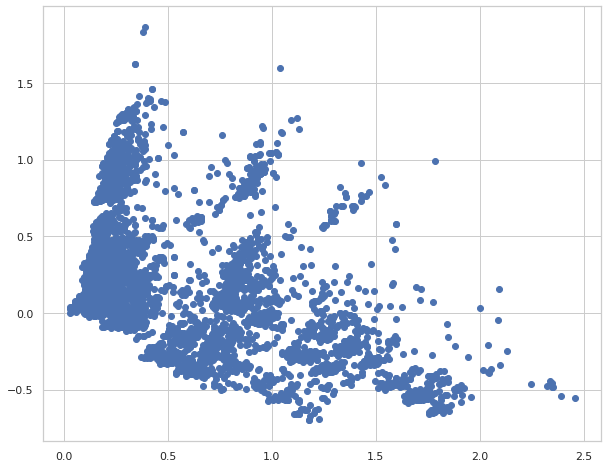

In [0]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(Z_2d[:, 0], Z_2d[:, 1])
plt.show()

In [0]:
pca.explained_variance_ratio_

array([0.04521225, 0.03878755])

### Outliers

There are some outliers from the PCA plot that we may want to remove.

If not removed, these can cause very large cluster distances, and make it harder to find the optimum k.

In [0]:
from sklearn.covariance import EllipticEnvelope

# contaimnation can be tuned - percentage of the data
# you think are outliers (e.g. 0.001 = 0.1%)
ee = EllipticEnvelope(contamination=5e-3)

ee.fit(Z_2d) # use PCA because this method doesn't
             # work well on high dimensional data
             # just a visual aid

include = ee.predict(Z_2d)
print('outlier detection results: ', pd.Series(include).value_counts())

outlier detection results:   1    4975
-1      25
dtype: int64


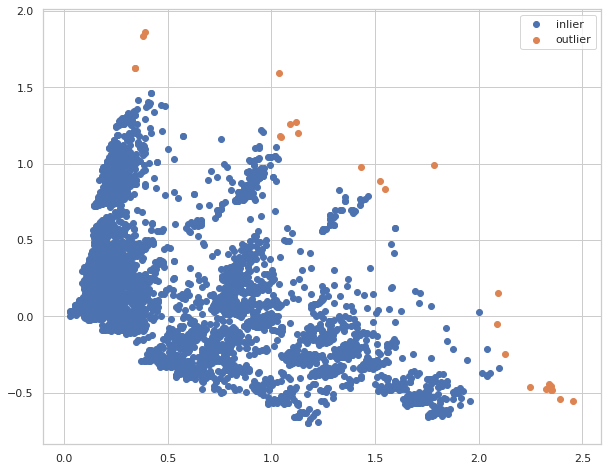

In [0]:
# plot the outliers
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(Z_2d[include==1, 0], Z_2d[include==1, 1], label='inlier')
ax.scatter(Z_2d[include==-1, 0], Z_2d[include==-1, 1], label='outlier')
ax.legend()
plt.show()

Play around with contamination values.

Let's go ahead and exclude the outliers from clustering

In [0]:
# mask to exclude the outliers
mask = (include==1)

# apply mask on the PCA
Z_2d_inlier = Z_2d[mask]

# mask out data to use for kmeans
X_inlier = X.tocsr()[mask]
X_inlier

<4975x6827 sparse matrix of type '<class 'numpy.float64'>'
	with 139857 stored elements in Compressed Sparse Row format>

In [0]:
# to see which rows correspond to the outliers
df.loc[~mask]

,reviews.title,reviews.text,"name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",name_Amazon - Echo Plus w/ Built-In Hub - Silver,name_Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,"name_Amazon - Kindle Voyage - 6"" - 4GB - Black",name_Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,"name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",name_Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player,"name_Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,"name_Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue","name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum","name_Fire HD 8 Tablet with Alexa, 8"" HD Display, 32 GB, Tangerine - with Special Offers","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case","name_Fire Tablet with Alexa, 7"" Display, 16 GB, Magenta - with Special Offers","name_Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black","name_Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Black, 6"" High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers"
205,Great product for the every day use.,I like the ease and usage of the amazon show. ...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
220,"Great Item, works great","Very neat item, fun to talk to. Easy set up to...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
227,Love love love it,Great product. Absolute love it. Alexa is fun ...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
264,Great product and at a great price.,Bought the Echo Show because of the display an...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
273,Great addition to the Amazon echo family,Love the Amazon Echo Show! The video display i...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
278,The Amazon Echo is a great product....,I love the ECHO- Alexa is awesome... it was a ...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
282,I switched the echo for the show and I love it!,The show is an all in one Alexa-enabled machin...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
422,"Great product, she loves it!",Bought this for my better half and she loves i...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
511,Love love love it!,Too many great things to say about the echo sh...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
539,Great addition to the Echo family,"This is a great addition to the Echo family, b...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


# Clustering

Let's run KMeans clustering to assign and then inspect the clusters.

Note that the PCA is just an approximation, actual clustering outcome can look different.

### KMeans
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#### Fit

- Original dimensions.
- After feature reduction to 100 dimensions (to compare clustering results if low variance columns are dropped)

In [0]:
# Run KMeans with 2 clusters on the original dimensions
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_inlier)

# Get cluster assignments, assign to y
y = kmeans.labels_

# Get metrics
score = silhouette_score(X_inlier, y)

In [0]:
y

array([0, 1, 1, ..., 1, 0, 1], dtype=int32)

In [0]:
# Run KMeans with 2 clusters after reducing to 100 dimensions
pca_100 = TruncatedSVD(n_components=100)
Z_100d = pca_100.fit_transform(X_inlier)
Z_100d

array([[ 0.08545244,  0.05362508,  0.02972103, ..., -0.12765747,
         0.07749255,  0.09834017],
       [ 0.98556244,  0.38885767, -0.3283519 , ...,  0.08017444,
         0.2144054 , -0.02115732],
       [ 1.32860185, -0.06442105,  0.07460261, ..., -0.00698773,
        -0.00968542,  0.02935525],
       ...,
       [ 1.30275432, -0.20668717, -0.02979532, ...,  0.20247874,
         0.24060354,  0.12586013],
       [ 0.53809726, -0.15917976,  0.56811361, ..., -0.04814934,
         0.09136014, -0.04702762],
       [ 1.06552927, -0.25176604, -0.54100141, ..., -0.01053586,
         0.08940657,  0.05729491]])

In [0]:
# Run KMeans with 2 clusters on 100 dimensions
kmeans_100d = KMeans(n_clusters=2)

kmeans_100d.fit(Z_100d)

# Get cluster assignments, assign to y_100d
y_100d = kmeans_100d.labels_
score_100d = silhouette_score(Z_100d, y_100d)

#### Visualise
- Scatter plots coloured according to clusters
- Mark the cluster centroids (KMeans-specific)

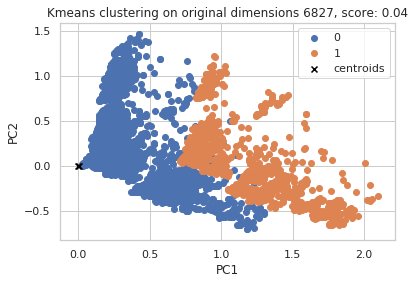

In [0]:
fig, ax = plt.subplots()

n_clusters = kmeans.n_clusters

for cluster_id in range(n_clusters):
    # create a mask for the current cluster_id and inliers
    mask = (y == cluster_id)
    
    # plot subset of samples using mask
    ax.scatter(Z_2d_inlier[mask, 0], Z_2d_inlier[mask, 1], label=cluster_id)

# mark the 2D cluster centroids on the same graph
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           marker='x', label='centroids', color='black')

ax.set_title(f'Kmeans clustering on original dimensions {X_inlier.shape[1]}, score: {score:.2f}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

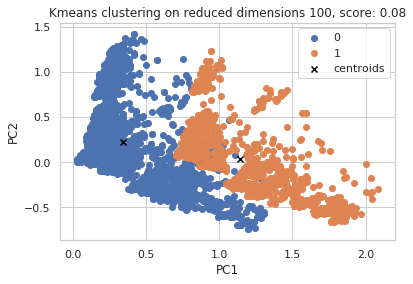

In [0]:
fig, ax = plt.subplots()

n_clusters = kmeans_100d.n_clusters

for cluster_id in range(n_clusters):
    mask = (y_100d == cluster_id)
    ax.scatter(Z_100d[mask, 0], Z_100d[mask, 1], label=cluster_id)

ax.scatter(kmeans_100d.cluster_centers_[:, 0],
               kmeans_100d.cluster_centers_[:, 1], marker='x',
               color='black', label='centroids')

ax.set_title(f'Kmeans clustering on reduced dimensions {Z_100d.shape[1]}, score: {score_100d:.2f}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

In [0]:
# Trying different feature reduction dimensions
best_kmeans = None
best_score = 0
best_dim = 100

for dim in range(100, 1001, 100): # 100-1000, step 100
    # reduce and then fit kmeans
    pca_dim = TruncatedSVD(n_components=dim)
    Z_dim = pca_dim.fit_transform(X_inlier)
    kmeans_dim = KMeans(n_clusters=2, n_jobs=4)
    kmeans_dim.fit(Z_dim)

    #scoring
    y_dim = kmeans_dim.labels_
    score_dim = silhouette_score(Z_dim, y_dim)
    print(dim, score_dim)
    if score_dim > best_score:
        best_score = score_dim
        best_kmeans = kmeans_dim
        best_dim = dim

best_score, best_kmeans, best_dim

100 0.07989599987966256
200 0.06739140190007069
300 0.06179193634171406
400 0.058442914183378006
500 0.05602023936840314
600 0.054150052009602545
700 0.05265795589233687
800 0.051470875156562776
900 0.050475114432491024
1000 0.04965403256597217


(0.07989599987966256,
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=2, n_init=10, n_jobs=4, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 100)

In [0]:
# Looks like n_dimensions=100 is the best so far
# Retrying with different k

best_kmeans_k = None
best_score_k = 0
best_k = 2
scores = []
inertias = []
ks = range(2, 10)

for k in ks:
    kmeans_k = KMeans(n_clusters=k, n_jobs=4)
    kmeans_k.fit(Z_100d)

    y_k = kmeans_k.labels_
    score_k = silhouette_score(Z_100d, y_k)
    print(k, score_k)
    if score_k > best_score_k:
        best_score_k = score_k
        best_kmeans_k = kmeans_k
        best_k = k
    scores.append(score_k)
    inertias.append(kmeans_k.inertia_)

best_score_k, best_kmeans_k, best_k

2 0.07990984540569865
3 0.06392143905269725
4 0.08170636735569156
5 0.09156239919481113
6 0.09538915088609826
7 0.10466487959121366
8 0.08880941972228867
9 0.10209069344632284


(0.10466487959121366,
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=7, n_init=10, n_jobs=4, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 7)

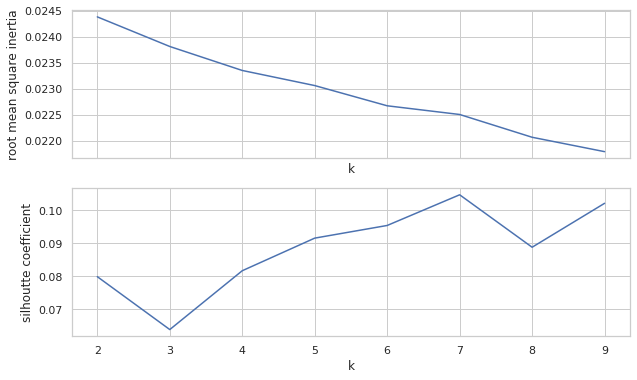

In [0]:
# Elbow plots
import numpy as np
fig, axes = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)

axes[0].plot(ks, np.sqrt(np.array(inertias))/len(y_k))
axes[0].set_xlabel('k')
axes[0].set_ylabel('root mean square inertia')

axes[1].plot(ks, scores)
axes[1].set_xlabel('k')
axes[1].set_ylabel('silhoutte coefficient')

plt.show()

## Observations

Do the clusters actually make sense?

To know for sure, we need to explore the data in each cluster.

In [0]:
# these are the cluster assignments with the highest score
best_y = best_kmeans_k.labels_

In [0]:
# Create a mask to explore the original text
# Note that the outliers need to be excluded.

df_nooutliers = df[include == 1]
df_nooutliers

,reviews.title,reviews.text,"name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black","name_All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",name_Amazon - Echo Plus w/ Built-In Hub - Silver,name_Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black,"name_Amazon - Kindle Voyage - 6"" - 4GB - Black",name_Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders,"name_Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7"" Screen",name_Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player,"name_Amazon Kindle E-Reader 6"" Wifi (8th Generation, 2016)",name_Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker,"name_Brand New Amazon Kindle Fire 16gb 7"" Ips Display Tablet Wifi 16 Gb Blue","name_Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum","name_Fire HD 8 Tablet with Alexa, 8"" HD Display, 32 GB, Tangerine - with Special Offers","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case","name_Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case","name_Fire Tablet with Alexa, 7"" Display, 16 GB, Magenta - with Special Offers","name_Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black","name_Kindle E-reader - White, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Black, 6"" High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers","name_Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers"
0,Too small,I thought it would be as big as small paper bu...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Great light reader. Easy to use at the beach,This kindle is light and easy to use especiall...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Great for the price,Didnt know how much i'd use a kindle so went f...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,A Great Buy,I am 100 happy with my purchase. I caught it o...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Solid entry-level Kindle. Great for kids,Solid entry level Kindle. Great for kids. Gift...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Good product,This is a great tablet for the price. Amazon i...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4996,Great Tablet,This tablet is the perfect size and so easy to...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4997,Great for kids or smaller needs,Purchased this for my son. Has room to upgrade...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4998,Very sturdy for a 5 year old,I had some thoughts about getting this for a 5...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


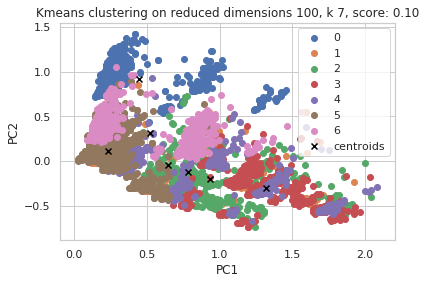

In [0]:
fig, ax = plt.subplots()

n_clusters = best_kmeans_k.n_clusters

for cluster_id in range(n_clusters):
    mask = (best_y == cluster_id)
    ax.scatter(Z_100d[mask, 0], Z_100d[mask, 1], label=cluster_id)

ax.scatter(best_kmeans_k.cluster_centers_[:, 0],
               best_kmeans_k.cluster_centers_[:, 1],
               marker='x', color='black', label='centroids')

ax.set_title(f'Kmeans clustering on reduced dimensions {Z_100d.shape[1]}, k {n_clusters}, score: {best_score_k:.2f}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
plt.show()

In [0]:
# cluster 0
df_nooutliers[best_y==0][['reviews.title', 'reviews.text']]

,reviews.title,reviews.text
96,Amazon Echo Show - Greatest Gift EVER,Great Gift for anyone. Very easy to setup. Coe...
97,Amazon Echo Show,Super excited to give this as a gift. It's sup...
98,Had to upgrade,"We bought this for mother in law, buying anoth..."
99,"Practical, easy to setup","Well designed, good sound, has everything Alex..."
100,Awesome having Show!,I have one Alexa and three Echo dots and havin...
...,...,...
936,,Best New Adult Toy in years! Wish I had purcha...
937,Echo Show,I own multiple echoes and I like the show the ...
938,Like Alexa,I bought several Alexa‚Äôs for Christmas gifts...
939,Best one yet,This one is the best...I have the dots but thi...


In [0]:
# cluster 5
df_nooutliers[best_y==5][['reviews.title', 'reviews.text']]

,reviews.title,reviews.text
0,Too small,I thought it would be as big as small paper bu...
5,Good ebook,This make an excellent ebook reader. Don't exp...
6,Light Weight - Makes a world of difference whe...,"I ordered this for my daughter, as I have the ..."
7,not good quality,I bought my Kindle about 2 months ago and the ...
8,best ebook,"amazon kindle is always the best ebook, upgrad..."
...,...,...
4987,So improved,My children love these kindles! They are so mu...
4988,EXCELLENT,This tablet is so great for school children to...
4990,Its a gift,Tablets are best used for personal reading. Cl...
4994,Very versatile,"I love this tablet/kindle. I can access email,..."


In [0]:
# cluster 2: family
df_nooutliers[best_y==2][['reviews.title', 'reviews.text']]

,reviews.title,reviews.text
2,Great for the price,Didnt know how much i'd use a kindle so went f...
14,Great for reading on the go,I use this every day on my commute. Great batt...
23,Good Deal for the Price,The Amazon Kindle is light weight and easy to ...
46,For mom,"Bought this for my 90+ year-old, totally no-te..."
51,Good for books,The kindle is good to download apps for books ...
...,...,...
4952,Easy enough for Grandpa,Tablet has worked without a hitch. We bought i...
4974,It was the I deal gift for my gran child,It great just a little small then what I would...
4983,awesome for games and movies,Bought this to use on my travels. comes in han...
4991,Good for my 11 year old son,My son uses the device to help him do his home...


## Further practice
- Try Hierarchical clustering. You can refer to the clustering reference notebook. 
- Compare the results of Hierarchical clustering with KMeans (silhoutte scores, PCA plot)
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

- Run Latent Dirichlet Analysis to extract topics for each cluster. Example:
https://github.com/lisaong/mldds-courseware/blob/master/03_TextImage/examples/Clustering_NLB_Articles.ipynb
